In [2]:
# STEP 1: COMPLETE DATA PREPROCESSING & FEATURE ENGINEERING
# =============================================================================
# This notebook prepares trademark similarity data for CNN+SVM training
# Output: Single clean CSV with visual/phonetic/semantic features
# =============================================================================

from datetime import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
import re
import logging
from dataclasses import dataclass
from deep_translator import GoogleTranslator
import chardet
import os
import warnings
import jellyfish
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# =============================================================================
# CONFIGURATION
# =============================================================================

TRADEMARK_LEXICON = {
    # Business & Commerce
    "company": {"ha": "kamfani", "yo": "ilé-iṣẹ́"},
    "business": {"ha": "kasuwanci", "yo": "iṣẹ́ owó"},
    "market": {"ha": "kasuwa", "yo": "ọjà"},
    "store": {"ha": "shago", "yo": "ṣọ́ọ̀bù"},
    "brand": {"ha": "alama", "yo": "àmì"},
    
    # Quality
    "premium": {"ha": "mai kyau", "yo": "iyebíye"},
    "super": {"ha": "babba", "yo": "púpọ̀"},
    "best": {"ha": "mafi kyau", "yo": "dára jùlọ"},
    "gold": {"ha": "zinariya", "yo": "wúrà"},
    "silver": {"ha": "azurfa", "yo": "fàdákà"},
    
    # Food & Beverage
    "coffee": {"ha": "kofi", "yo": "kọ́fí"},
    "tea": {"ha": "shayi", "yo": "tii"},
    "food": {"ha": "abinci", "yo": "oúnjẹ"},
    "restaurant": {"ha": "gidan cin abinci", "yo": "ilé oúnjẹ"},
    
    # Technology
    "tech": {"ha": "fasaha", "yo": "ìmọ̀-ẹrọ"},
    "digital": {"ha": "na dijital", "yo": "oníjìtù"},
    "smart": {"ha": "mai hankali", "yo": "ológbọ́n"},
    "online": {"ha": "kan layi", "yo": "lórí ayélujára"},
    
    # Common terms
    "new": {"ha": "sabon", "yo": "títun"},
    "fresh": {"ha": "sabo", "yo": "tuntun"},
    "natural": {"ha": "na halitta", "yo": "àdáyébá"},
}

def get_incremented_filename(base_name: str) -> str:
    """
    Returns a filename that doesn't exist yet by appending _1, _2, etc.
    Example: 'data.csv' → 'data_1.csv' if 'data.csv' exists.
    """
    if not os.path.exists(base_name):
        return base_name

    name, ext = os.path.splitext(base_name)
    counter = 1
    while True:
        new_name = f"{name}_{counter}{ext}"
        if not os.path.exists(new_name):
            return new_name
        counter += 1

@dataclass
class PreprocessingConfig:
    """Configuration for the entire pipeline"""
    # Data sampling
    max_rows: Optional[int] = None  # None = process all rows
    sampling_strategy: str = 'first'  # 'first', 'random', or 'all'
    
    # Translation
    translate_to_english: bool = True
    translate_to_local: bool = True
    
    # Cleaning
    fix_encoding: bool = True
    remove_duplicates: bool = True
    handle_missing: str = 'drop'
    
    # Negative pair generation
    negative_ratio: float = 1.0
    negative_strategy: str = 'mixed'
    
    # Output
    output_filename: str = 'trademark_similarity_dataset_final.csv'
    save_visualizations: bool = True

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def validate_wordmark(text: str) -> bool:
    """Check if a wordmark is valid (not empty/null)"""
    if pd.isna(text):
        return False
    text = str(text).strip()
    return len(text) > 0 and text.lower() not in ['nan', 'none', 'null', '']

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Remove all rows with invalid wordmarks"""
    initial_len = len(df)
    
    # Remove rows with missing/invalid wordmarks
    if 'mark1_wordmark' in df.columns and 'mark2_wordmark' in df.columns:
        df = df[
            df['mark1_wordmark'].apply(validate_wordmark) &
            df['mark2_wordmark'].apply(validate_wordmark)
        ].copy()
    
    removed = initial_len - len(df)
    if removed > 0:
        logger.info(f"🧹 Removed {removed} rows with invalid wordmarks")
    
    return df

# =============================================================================
# ENHANCED TRANSLATOR
# =============================================================================

class EnhancedTranslator:
    """Multi-strategy translator: Lexicon → HuggingFace → Google Translate"""
    
    def __init__(self):
        self.lexicon = TRADEMARK_LEXICON
        self.google_translators = {
            'ha': GoogleTranslator(source='en', target='ha'),
            'yo': GoogleTranslator(source='en', target='yo')
        }
        self.cache = {}
        self.stats = {'lexicon': 0, 'google': 0, 'cache': 0}
    
    def translate_word(self, word: str, target_lang: str) -> str:
        """Translate a single word"""
        if not word or not word.strip():
            return ""
        
        word_lower = word.lower().strip()
        cache_key = f"{target_lang}:{word_lower}"
        
        # Check cache
        if cache_key in self.cache:
            self.stats['cache'] += 1
            return self.cache[cache_key]
        
        # Try lexicon
        if word_lower in self.lexicon:
            translation = self.lexicon[word_lower].get(target_lang, word)
            self.stats['lexicon'] += 1
            self.cache[cache_key] = translation
            return translation
        
        # Fallback to Google Translate
        try:
            translation = self.google_translators[target_lang].translate(word)
            self.stats['google'] += 1
            self.cache[cache_key] = translation
            return translation
        except Exception:
            return word
    
    def translate_text(self, text: str, target_lang: str) -> str:
        """Translate full text"""
        if pd.isna(text) or not str(text).strip():
            return ""
        
        words = re.findall(r"\b\w+\b", str(text))
        translated = [self.translate_word(w, target_lang) for w in words]
        return " ".join(translated)

# =============================================================================
# FEATURE EXTRACTOR (FIXED PHONETIC FEATURES)
# =============================================================================

class FeatureExtractor:
    """Extract visual, phonetic, and semantic features"""
    
    def __init__(self):
        self.semantic_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    
    def extract_visual_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract character-level visual similarity features"""
        logger.info("🔍 Extracting visual features...")
        
        df['visual_levenshtein'] = df.apply(
            lambda row: jellyfish.levenshtein_distance(
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ), axis=1
        )
        
        df['visual_jaro_winkler'] = df.apply(
            lambda row: jellyfish.jaro_winkler_similarity(
                str(row['mark1_wordmark']), 
                str(row['mark2_wordmark'])
            ), axis=1
        )
        
        return df
    
    def extract_phonetic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract phonetic similarity features
        FIXED: Now uses English translations for better phonetic matching
        """
        logger.info("👂 Extracting phonetic features...")
        
        # Use English translations for phonetic comparison
        def safe_soundex(text):
            try:
                if pd.isna(text) or not str(text).strip():
                    return ""
                return jellyfish.soundex(str(text))
            except:
                return ""
        
        def safe_metaphone(text):
            try:
                if pd.isna(text) or not str(text).strip():
                    return ""
                return jellyfish.metaphone(str(text))
            except:
                return ""
        
        # Soundex comparison on English wordmarks
        df['soundex_match'] = df.apply(
            lambda row: int(
                safe_soundex(row.get('mark1_wordmark_en', '')) == 
                safe_soundex(row.get('mark2_wordmark_en', ''))
                and safe_soundex(row.get('mark1_wordmark_en', '')) != ""
            ), axis=1
        )
        
        # Metaphone comparison on English wordmarks
        df['metaphone_match'] = df.apply(
            lambda row: int(
                safe_metaphone(row.get('mark1_wordmark_en', '')) == 
                safe_metaphone(row.get('mark2_wordmark_en', ''))
                and safe_metaphone(row.get('mark1_wordmark_en', '')) != ""
            ), axis=1
        )
        
        return df
    
    def _safe_encode(self, texts: List[str]) -> np.ndarray:
        """Safely encode texts handling NaN/empty values"""
        clean_texts = [str(t) if pd.notna(t) and str(t).strip() else "" for t in texts]
        return self.semantic_model.encode(clean_texts, show_progress_bar=False)
    
    def extract_semantic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract semantic similarity features for all languages"""
        logger.info("🧠 Extracting semantic features...")
        
        for lang in ['en', 'ha', 'yo']:
            col1 = f'mark1_wordmark_{lang}'
            col2 = f'mark2_wordmark_{lang}'
            
            if col1 in df.columns and col2 in df.columns:
                emb1 = self._safe_encode(df[col1].tolist())
                emb2 = self._safe_encode(df[col2].tolist())
                
                df[f'semantic_similarity_{lang}'] = [
                    float(cosine_similarity([e1], [e2])[0][0])
                    for e1, e2 in zip(emb1, emb2)
                ]
        
        return df
    
    def extract_all(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract all features"""
        df = self.extract_visual_features(df)
        df = self.extract_phonetic_features(df)
        df = self.extract_semantic_features(df)
        return df

# =============================================================================
# MAIN PREPROCESSOR
# =============================================================================

class TrademarkPreprocessor:
    """Complete preprocessing pipeline"""
    
    def __init__(self, config: PreprocessingConfig = None):
        self.config = config or PreprocessingConfig()
        self.translator = EnhancedTranslator()
        self.feature_extractor = FeatureExtractor()
        self.pt_to_en = GoogleTranslator(source='pt', target='en')
        self.cache = {}
    
    def load_data(self, file_path: str) -> pd.DataFrame:
        """Load CSV with encoding detection"""
        logger.info("📂 Loading dataset...")
        
        # Detect encoding
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read(100000))
        encoding = result['encoding']
        
        # Try multiple encodings
        for enc in [encoding, 'MacRoman', 'utf-8', 'latin-1']:
            try:
                df = pd.read_csv(file_path, encoding=enc)
                logger.info(f"✓ Loaded with encoding: {enc}")
                logger.info(f"   Shape: {df.shape}")
                return df
            except Exception:
                continue
        
        raise ValueError("Could not load CSV with any encoding")
    
    def extract_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract and rename relevant columns (excluding class info)"""
        logger.info("📋 Extracting relevant columns...")
        
        column_mapping = {
            'Process number RM': 'mark1_id',
            'Process number TM': 'mark2_id',
            'Name RM': 'mark1_wordmark',
            'Name TM': 'mark2_wordmark',
            'Status RM': 'mark1_status',
            'Status TM': 'mark2_status',
        }
        
        available = [c for c in column_mapping.keys() if c in df.columns]
        df_proc = df[available].copy()
        df_proc.rename(columns=column_mapping, inplace=True)
        df_proc['label'] = 1  # All are similar pairs
        
        return df_proc
    
    def clean_text(self, text: str) -> str:
        """Clean text"""
        if pd.isna(text) or not str(text).strip():
            return ""
        
        text = str(text)
        
        # Fix encoding issues
        fixes = {
            'v�': 'ç', 'v�o': 'ção', 'v�': 'í', 'v=': 'ó', '?': ''
        }
        for bad, good in fixes.items():
            text = text.replace(bad, good)
        
        return ' '.join(text.split()).strip()
    
    def translate_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """Translate wordmarks to English, Hausa, Yoruba"""
        logger.info("🌍 Translating dataset...")
        
        for col in ['mark1_wordmark', 'mark2_wordmark']:
            if col not in df.columns:
                continue
            
            # Clean first
            df[col] = df[col].apply(self.clean_text)
            
            # Portuguese → English
            en_col = col.replace('_wordmark', '_wordmark_en')
            df[en_col] = df[col].apply(
                lambda x: self.pt_to_en.translate(x) if x else ""
            )
            
            # English → Hausa & Yoruba
            for lang in ['ha', 'yo']:
                lang_col = col.replace('_wordmark', f'_wordmark_{lang}')
                df[lang_col] = df[en_col].apply(
                    lambda x: self.translator.translate_text(x, lang)
                )
        
        # Show translation stats
        stats = self.translator.stats
        total = sum(stats.values())
        if total > 0:
            logger.info(f"   Lexicon: {stats['lexicon']} ({stats['lexicon']/total*100:.1f}%)")
            logger.info(f"   Google: {stats['google']} ({stats['google']/total*100:.1f}%)")
        
        return df
    
    def generate_negative_pairs(self, df: pd.DataFrame) -> pd.DataFrame:
        """Generate dissimilar pairs (without class filtering)"""
        logger.info(f"🔄 Generating negative pairs (ratio: {self.config.negative_ratio})...")
        
        # Get valid wordmarks
        all_marks = list(set(
            df['mark1_wordmark'].tolist() + df['mark2_wordmark'].tolist()
        ))
        all_marks = [m for m in all_marks if validate_wordmark(m)]
        
        if len(all_marks) < 2:
            logger.warning("⚠ Not enough wordmarks for negative pairs")
            return pd.DataFrame()
        
        # Track existing pairs
        existing = set()
        for _, row in df.iterrows():
            pair = tuple(sorted([
                str(row['mark1_wordmark']),
                str(row['mark2_wordmark'])
            ]))
            existing.add(pair)
        
        # Generate negatives
        n_negative = int(len(df) * self.config.negative_ratio)
        negatives = []
        attempts = 0
        max_attempts = n_negative * 100
        
        while len(negatives) < n_negative and attempts < max_attempts:
            attempts += 1
            
            mark1 = np.random.choice(all_marks)
            mark2 = np.random.choice(all_marks)
            
            # Validate
            if mark1 == mark2:
                continue
            
            pair = tuple(sorted([mark1, mark2]))
            if pair in existing:
                continue
            
            # Length difference check for dissimilarity
            if self.config.negative_strategy == 'mixed':
                len_diff = abs(len(mark1) - len(mark2))
                if len_diff < 3:  # Must have some length difference
                    continue
            
            existing.add(pair)
            negatives.append({
                'mark1_wordmark': mark1,
                'mark2_wordmark': mark2,
                'label': 0,
                'pair_type': 'negative'
            })
        
        logger.info(f"✓ Generated {len(negatives)} negative pairs")
        return pd.DataFrame(negatives)
    
    def add_basic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add basic statistical features"""
        df['mark1_length'] = df['mark1_wordmark'].str.len()
        df['mark2_length'] = df['mark2_wordmark'].str.len()
        df['length_diff'] = abs(df['mark1_length'] - df['mark2_length'])
        return df
    
    def process(self, file_path: str) -> pd.DataFrame:
        """Complete pipeline"""
        logger.info("=" * 80)
        logger.info("STEP 1: TRADEMARK SIMILARITY DATA PREPROCESSING")
        logger.info("=" * 80)
        
        # 1. Load
        df = self.load_data(file_path)
        
        # 2. Extract columns (no class info)
        df = self.extract_columns(df)
        
        # 3. Sample (if configured)
        if self.config.max_rows and self.config.sampling_strategy != 'all':
            n = min(self.config.max_rows, len(df))
            if self.config.sampling_strategy == 'first':
                df = df.head(n).copy()
            elif self.config.sampling_strategy == 'random':
                df = df.sample(n=n, random_state=42).copy()
            logger.info(f"📝 Sampled {n} rows ({self.config.sampling_strategy})")
        
        # 4. Clean
        df = clean_dataframe(df)
        
        # 5. Remove duplicates
        initial = len(df)
        df['_pair_key'] = df.apply(
            lambda r: tuple(sorted([
                str(r['mark1_wordmark']),
                str(r['mark2_wordmark'])
            ])), axis=1
        )
        df = df.drop_duplicates(subset='_pair_key').drop('_pair_key', axis=1)
        logger.info(f"🗑️  Removed {initial - len(df)} duplicates")
        
        # 6. Translate
        df['pair_type'] = 'positive'
        df = self.translate_dataset(df)
        
        # 7. Generate negatives
        negative_df = self.generate_negative_pairs(df)
        
        if len(negative_df) > 0:
            # Translate negatives
            for col in ['mark1_wordmark', 'mark2_wordmark']:
                en_col = col.replace('_wordmark', '_wordmark_en')
                negative_df[en_col] = negative_df[col].apply(
                    lambda x: self.pt_to_en.translate(x) if x else ""
                )
                
                for lang in ['ha', 'yo']:
                    lang_col = col.replace('_wordmark', f'_wordmark_{lang}')
                    negative_df[lang_col] = negative_df[en_col].apply(
                        lambda x: self.translator.translate_text(x, lang)
                    )
            
            # Combine
            df = pd.concat([df, negative_df], ignore_index=True)
            df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # 8. Add features
        df = self.add_basic_features(df)
        df = self.feature_extractor.extract_all(df)
        
        # 9. Final cleaning
        df = clean_dataframe(df)
        
        logger.info("=" * 80)
        logger.info("✅ PREPROCESSING COMPLETE")
        logger.info(f"   Total pairs: {len(df)}")
        logger.info(f"   Positive: {(df['label']==1).sum()}")
        logger.info(f"   Negative: {(df['label']==0).sum()}")
        logger.info(f"   Features: {len(df.columns)}")
        logger.info("=" * 80)
        
        return df

# =============================================================================
# EXPLORATORY DATA ANALYSIS (SEPARATE VISUALIZATIONS)
# =============================================================================

class TrademarkEDA:
    """Comprehensive EDA with separate, readable visualizations"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def create_visualizations(self, output_dir: str = '.'):
        """Create separate visualization files for better readability"""
        os.makedirs(output_dir, exist_ok=True)
        
        # 1. Label Distribution
        self._plot_label_distribution(output_dir)
        
        # 2. Wordmark Length Distribution
        self._plot_length_distribution(output_dir)
        
        # 3. Visual Similarity Distribution
        self._plot_visual_similarity(output_dir)
        
        # 4. Phonetic Match Distribution
        self._plot_phonetic_matches(output_dir)
        
        # 5. Semantic Similarity by Language
        self._plot_semantic_similarity(output_dir)
        
        # 6. Feature Correlation Heatmap
        self._plot_correlation_heatmap(output_dir)
        
        # 7. Length Difference by Label
        self._plot_length_difference(output_dir)
        
        logger.info(f"📊 All visualizations saved to: {output_dir}/")
    
    def _plot_label_distribution(self, output_dir):
        fig, ax = plt.subplots(figsize=(8, 8))
        label_counts = self.df['label'].value_counts()
        colors = ['#2ecc71', '#e74c3c']
        ax.pie(label_counts.values, labels=['Similar', 'Dissimilar'], 
               autopct='%1.1f%%', startangle=90, colors=colors,
               textprops={'fontsize': 14, 'weight': 'bold'})
        ax.set_title('Label Distribution', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/01_label_distribution.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_length_distribution(self, output_dir):
        fig, ax = plt.subplots(figsize=(12, 6))
        all_lengths = pd.concat([self.df['mark1_length'], self.df['mark2_length']])
        ax.hist(all_lengths, bins=30, color='coral', edgecolor='black', alpha=0.7)
        ax.axvline(all_lengths.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {all_lengths.mean():.1f}')
        ax.set_xlabel('Wordmark Length (characters)', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('Wordmark Length Distribution', fontsize=16, fontweight='bold', pad=20)
        ax.legend(fontsize=12)
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/02_length_distribution.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_visual_similarity(self, output_dir):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Levenshtein
        for label in [0, 1]:
            subset = self.df[self.df['label'] == label]['visual_levenshtein']
            ax1.hist(subset, bins=20, alpha=0.6, 
                    label=f'{"Similar" if label==1 else "Dissimilar"}')
        ax1.set_xlabel('Levenshtein Distance', fontsize=12)
        ax1.set_ylabel('Frequency', fontsize=12)
        ax1.set_title('Visual Similarity: Levenshtein Distance', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(alpha=0.3)
        
        # Jaro-Winkler
        for label in [0, 1]:
            subset = self.df[self.df['label'] == label]['visual_jaro_winkler']
            ax2.hist(subset, bins=20, alpha=0.6, 
                    label=f'{"Similar" if label==1 else "Dissimilar"}')
        ax2.set_xlabel('Jaro-Winkler Similarity', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.set_title('Visual Similarity: Jaro-Winkler', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/03_visual_similarity.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_phonetic_matches(self, output_dir):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Soundex
        soundex_counts = self.df.groupby(['label', 'soundex_match']).size().unstack(fill_value=0)
        soundex_counts.plot(kind='bar', ax=ax1, color=['#e74c3c', '#2ecc71'])
        ax1.set_xlabel('Label', fontsize=12)
        ax1.set_ylabel('Count', fontsize=12)
        ax1.set_title('Phonetic Match: Soundex', fontsize=14, fontweight='bold')
        ax1.set_xticklabels(['Dissimilar', 'Similar'], rotation=0)
        ax1.legend(['No Match', 'Match'], fontsize=11)
        ax1.grid(alpha=0.3)
        
        # Metaphone
        metaphone_counts = self.df.groupby(['label', 'metaphone_match']).size().unstack(fill_value=0)
        metaphone_counts.plot(kind='bar', ax=ax2, color=['#e74c3c', '#2ecc71'])
        ax2.set_xlabel('Label', fontsize=12)
        ax2.set_ylabel('Count', fontsize=12)
        ax2.set_title('Phonetic Match: Metaphone', fontsize=14, fontweight='bold')
        ax2.set_xticklabels(['Dissimilar', 'Similar'], rotation=0)
        ax2.legend(['No Match', 'Match'], fontsize=11)
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/04_phonetic_matches.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_semantic_similarity(self, output_dir):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        langs = ['en', 'ha', 'yo']
        
        # Distributions by label for each language
        for idx, lang in enumerate(langs):
            row = idx // 2
            col = idx % 2
            ax = axes[row, col]
            
            for label in [0, 1]:
                subset = self.df[self.df['label'] == label][f'semantic_similarity_{lang}']
                ax.hist(subset, bins=20, alpha=0.6, 
                       label=f'{"Similar" if label==1 else "Dissimilar"}')
            
            lang_names = {'en': 'English', 'ha': 'Hausa', 'yo': 'Yoruba'}
            ax.set_xlabel('Cosine Similarity', fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.set_title(f'Semantic Similarity: {lang_names[lang]}', fontsize=14, fontweight='bold')
            ax.legend(fontsize=11)
            ax.grid(alpha=0.3)
        
        # Comparison bar chart
        ax = axes[1, 1]
        means = [self.df[f'semantic_similarity_{lang}'].mean() for lang in langs]
        colors = ['#3498db', '#e67e22', '#9b59b6']
        bars = ax.bar(['English', 'Hausa', 'Yoruba'], means, color=colors, alpha=0.7, edgecolor='black')
        ax.set_ylabel('Average Similarity', fontsize=12)
        ax.set_title('Semantic Similarity by Language', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/05_semantic_similarity.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_correlation_heatmap(self, output_dir):
        fig, ax = plt.subplots(figsize=(14, 12))
        
        feature_cols = [
            'visual_levenshtein', 'visual_jaro_winkler',
            'soundex_match', 'metaphone_match',
            'semantic_similarity_en', 'semantic_similarity_ha', 'semantic_similarity_yo',
            'length_diff', 'label'
        ]
        
        corr_data = self.df[feature_cols].corr()
        sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                   ax=ax, cbar_kws={'label': 'Correlation'}, 
                   square=True, linewidths=1)
        ax.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/06_correlation_heatmap.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def _plot_length_difference(self, output_dir):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        data_to_plot = [
            self.df[self.df['label'] == 0]['length_diff'],
            self.df[self.df['label'] == 1]['length_diff']
        ]
        
        bp = ax.boxplot(data_to_plot, labels=['Dissimilar', 'Similar'],
                       patch_artist=True, showmeans=True)
        
        colors = ['#e74c3c', '#2ecc71']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_xlabel('Label', fontsize=12)
        ax.set_ylabel('Length Difference', fontsize=12)
        ax.set_title('Length Difference by Label', fontsize=16, fontweight='bold', pad=20)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/07_length_difference.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def print_statistics(self):
        """Print detailed statistics"""
        print("\n" + "=" * 80)
        print("DATASET STATISTICS")
        print("=" * 80)
        
        print(f"\n📊 Dataset Overview:")
        print(f"   Total pairs: {len(self.df):,}")
        print(f"   Similar pairs: {(self.df['label']==1).sum():,} ({(self.df['label']==1).mean()*100:.1f}%)")
        print(f"   Dissimilar pairs: {(self.df['label']==0).sum():,} ({(self.df['label']==0).mean()*100:.1f}%)")
        print(f"   Total features: {len(self.df.columns)}")
        
        print(f"\n📏 Wordmark Statistics:")
        print(f"   Average length: {self.df['mark1_length'].mean():.1f} characters")
        print(f"   Min length: {self.df['mark1_length'].min()}")
        print(f"   Max length: {self.df['mark1_length'].max()}")
        
        print(f"\n🎯 Feature Quality:")
        print(f"   Visual similarity (Jaro-Winkler): {self.df['visual_jaro_winkler'].mean():.3f}")
        print(f"   Phonetic match rate (Soundex): {self.df['soundex_match'].mean()*100:.1f}%")
        print(f"   Phonetic match rate (Metaphone): {self.df['metaphone_match'].mean()*100:.1f}%")
        print(f"   Semantic similarity (EN): {self.df['semantic_similarity_en'].mean():.3f}")
        print(f"   Semantic similarity (HA): {self.df['semantic_similarity_ha'].mean():.3f}")
        print(f"   Semantic similarity (YO): {self.df['semantic_similarity_yo'].mean():.3f}")
        
        print("\n" + "=" * 80)

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Run complete pipeline"""
    
    # Configuration
    config = PreprocessingConfig(
        max_rows=5,  # Set to None to process all data
        sampling_strategy='first',
        negative_ratio=1.0,
        negative_strategy='mixed',
        output_filename='trademark_similarity_dataset_final.csv',
        save_visualizations=True
    )
    
    # Process
    preprocessor = TrademarkPreprocessor(config)
    df = preprocessor.process('trademark_file.csv')
    
    # EDA
    eda = TrademarkEDA(df)
    eda.print_statistics()
    
    if config.save_visualizations:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        viz_dir = f"eda_visualizations_{timestamp}"
        eda.create_visualizations(viz_dir)
    
    # Save final dataset
    # Generate a safe, non-overwriting filename
    safe_output_file = get_incremented_filename(config.output_filename)
    df.to_csv(safe_output_file, index=False, encoding='utf-8')
    logger.info(f"\n💾 Final dataset saved: {safe_output_file}")
    logger.info(f"   Shape: {df.shape}")
    logger.info(f"   File size: {os.path.getsize(safe_output_file) / 1024**2:.2f} MB")
    
    # Show sample
    print("\n" + "=" * 80)
    print("SAMPLE DATA (First 5 rows)")
    print("=" * 80)
    display_cols = [
        'mark1_wordmark', 'mark2_wordmark', 'label',
        'visual_levenshtein', 'soundex_match', 'metaphone_match', 'semantic_similarity_en'
    ]
    print(df[display_cols].head(5).to_string(index=False))
    
    print("\n✅ STEP 1 COMPLETE - Ready for Step 2 (CNN Architecture)")
    print(f"   Use file: {safe_output_file}")
    print(f"   Visualizations: {viz_dir} directory")

    with open('pipeline_config.json', 'w') as f:
        json.dump({
            'processed_data_file': safe_output_file,
            'timestamp': datetime.now().isoformat()
        }, f)
    
    return df

# Run pipeline
if __name__ == "__main__":
    final_df = main()

c:\Users\bubashir\trademark-similarity-engine\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: Use pytorch device_name: cpu
INFO: Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
INFO: ================================================================================
INFO: STEP 1: TRADEMARK SIMILARITY DATA PREPROCESSING
INFO: ================================================================================
INFO: 📂 Loading dataset...
INFO: ✓ Loaded with encoding: MacRoman
INFO:    Shape: (18737, 18)
INFO: 📋 Extracting relevant columns...
INFO: 📝 Sampled 5 rows (first)
INFO: 🗑️  Removed 1 duplicates
INFO: 🌍 Translating dataset...
INFO:    Lexicon: 0 (0.0%)
INFO:    Google: 30 (75.0%)
INFO: 🔄 Generating negative pairs (ratio: 1.0)...
INFO: ✓ Generated 4 negative pairs
INFO: 🔍 Extracting visual features...
INFO: 👂 Extracting phonetic features...
INFO: 🧠 Extracting semantic features...
INFO: ================================================================================
INFO: ✅ PREPROCESSING COMPLETE
INFO:    Total pairs: 8
INFO:    Positive: 4
INFO:    


DATASET STATISTICS

📊 Dataset Overview:
   Total pairs: 8
   Similar pairs: 4 (50.0%)
   Dissimilar pairs: 4 (50.0%)
   Total features: 24

📏 Wordmark Statistics:
   Average length: 13.0 characters
   Min length: 7
   Max length: 20

🎯 Feature Quality:
   Visual similarity (Jaro-Winkler): 0.371
   Phonetic match rate (Soundex): 12.5%
   Phonetic match rate (Metaphone): 0.0%
   Semantic similarity (EN): 0.526
   Semantic similarity (HA): 0.578
   Semantic similarity (YO): 0.584



INFO: 📊 All visualizations saved to: eda_visualizations_20260122_115637/
INFO: 
💾 Final dataset saved: trademark_similarity_dataset_final_2.csv
INFO:    Shape: (8, 24)
INFO:    File size: 0.00 MB



SAMPLE DATA (First 5 rows)
      mark1_wordmark    mark2_wordmark  label  visual_levenshtein  soundex_match  metaphone_match  semantic_similarity_en
   PADARIA MERCAPv…O         MERCOPv…O      1                   9              1                0                0.882134
          OFFER % TV PADARIA MERCAPv…O      0                  15              0                0                0.152453
             LeOffer        OFFER % TV      1                  10              0                0                0.248213
           MERCOPv…O JAZZ IMOBILIv≈RIA      0                  15              0                0                0.260845
CANTINETTA DEI FIORI          DI FIORI      1                  12              0                0                0.852821

✅ STEP 1 COMPLETE - Ready for Step 2 (CNN Architecture)
   Use file: trademark_similarity_dataset_final_2.csv
   Visualizations: eda_visualizations_20260122_115637 directory


STEP 2 & 3: CNN+SVM HYBRID MODEL WITH LINGUISTIC FEATURES
✅ Using dataset from Step 1: trademark_similarity_dataset_final_2.csv

STEP 2: TRAINING CNN+SVM HYBRID MODEL

📂 Loading preprocessed data...
✓ Loaded 8 trademark pairs
  Positive: 4
  Negative: 4
✓ Extracted 10 linguistic features

📊 Data Split:
   Train: 4 (2 positive)
   Val:   2 (1 positive)
   Test:  2 (1 positive)

🏗️  Building Character-level CNN Encoder...
✓ Built character tokenizer (vocab size: 23)

🔤 Encoding texts to sequences...

🏗️  CNN Architecture:


Model: "siamese_cnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mark1 (InputLayer)  │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mark2 (InputLayer)  │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_encoder         │ (None, 64)        │    204,448 │ mark1[0][0],      │
│ (Functional)        │                   │            │ mark2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64)        │          0 │ cnn_encoder[0][0… │
│                     │                   │            │ cnn_encoder[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 64)        │          0 │ cnn_encoder[0][0… │
│ (Multiply)          │                   │            │ cnn_encoder[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ cnn_encoder[0][0… │
│ (Concatenate)       │                   │            │ cnn_encoder[1][0… │
│                     │                   │            │ lambda_2[0][0],   │
│                     │                   │            │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense_1  │ (None, 128)       │     32,896 │ concatenate_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dropout  │ (None, 128)       │          0 │ classifier_dense… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense_2  │ (None, 64)        │      8,256 │ classifier_dropo… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ classifier_dense… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,665 (959.63 KB)

 Trainable params: 245,665 (959.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training CNN...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5000 - loss: 0.6927 - precision: 0.5000 - recall: 0.5000
Epoch 1: val_loss improved from None to 0.69172, saving model to models\best_cnn_model.h5



Epoch 1: finished saving model to models\best_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.6927 - precision: 0.5000 - recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6917 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6800 - precision: 0.6667 - recall: 1.0000
Epoch 2: val_loss did not improve from 0.69172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7500 - loss: 0.6800 - precision: 0.6667 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6920 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.6712 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_loss did not improve from 0.69172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.6712 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6927 - val_precision: 


Epoch 6: finished saving model to models\best_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7500 - loss: 0.6937 - precision: 1.0000 - recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6915 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6981 - precision: 0.6667 - recall: 1.0000
Epoch 7: val_loss improved from 0.69147 to 0.69080, saving model to models\best_cnn_model.h5



Epoch 7: finished saving model to models\best_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7500 - loss: 0.6981 - precision: 0.6667 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6908 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.6417 - precision: 1.0000 - recall: 1.0000
Epoch 8: val_loss improved from 0.69080 to 0.69051, saving model to models\best_cnn_model.h5



Epoch 8: finished saving model to models\best_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.6417 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6905 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 0.7701 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 9: val_loss did not improve from 0.69051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0000e+00 - loss: 0.7701 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6908 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.6926 - precision: 0.5000 - recall: 0.5000
Epoch 10: val_loss did not improve from 0.69051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5000 - loss: 0.6926 - precision: 0.5000 - recall: 0.5000 - val_accuracy: 0.5000 - val_l

FileNotFoundError: [Errno 2] No such file or directory: 'results\\cnn_training_history.png'

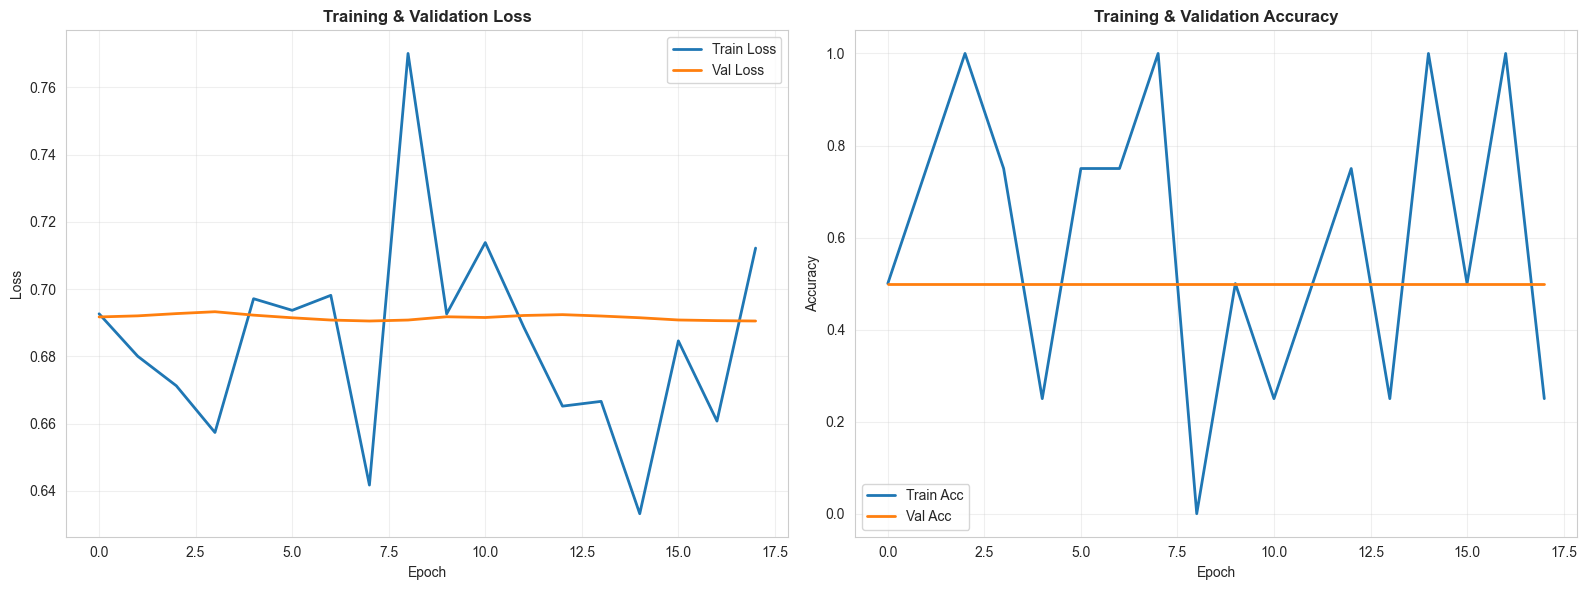

In [ ]:
# STEP 2 & 3: CNN+SVM ARCHITECTURE WITH ADVANCED FEATURE ENGINEERING
# =============================================================================
# This notebook builds a hybrid CNN+SVM model for trademark similarity detection
# Input: Processed CSV from Step 1
# Output: Trained models + evaluation metrics
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import pickle
import json
from pathlib import Path
from datetime import datetime

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Machine Learning
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Feature Engineering (from Step 1)
import jellyfish
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 80)
print("STEP 2 & 3: CNN+SVM HYBRID MODEL WITH LINGUISTIC FEATURES")
print("=" * 80)

# =============================================================================
# CONFIGURATION
# =============================================================================

class ModelConfig:
    """Configuration for model training"""
    # Data
    try:
        with open('pipeline_config.json', 'r') as f:
            pipeline_cfg = json.load(f)
        DATA_FILE = pipeline_cfg['processed_data_file']
        print(f"✅ Using dataset from Step 1: {DATA_FILE}")
    except FileNotFoundError:
        raise FileNotFoundError("Run Step 1 first to generate the processed dataset!")
    
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    
    # CNN Architecture
    MAX_SEQUENCE_LENGTH = 50
    MAX_VOCAB_SIZE = 10000
    EMBEDDING_DIM = 128
    CNN_FILTERS = [128, 64, 32]
    CNN_KERNEL_SIZES = [3, 4, 5]
    DROPOUT_RATE = 0.5
    
    # Training
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 0.001
    EARLY_STOPPING_PATIENCE = 10
    
    # SVM
    SVM_KERNEL = 'rbf'
    SVM_C = 1.0
    SVM_GAMMA = 'scale'
    
    # Output
    MODEL_DIR = Path('models')
    RESULTS_DIR = Path('results')
    
    def __post_init__(self):
        self.MODEL_DIR.mkdir(exist_ok=True)
        self.RESULTS_DIR.mkdir(exist_ok=True)

config = ModelConfig()

# =============================================================================
# DATA LOADER
# =============================================================================

class TrademarkDataLoader:
    """Load and prepare trademark data"""
    
    def __init__(self, file_path: str):
        self.df = pd.read_csv(file_path)
        print(f"✓ Loaded {len(self.df)} trademark pairs")
        print(f"  Positive: {(self.df['label']==1).sum()}")
        print(f"  Negative: {(self.df['label']==0).sum()}")
    
    def get_text_pairs(self) -> Tuple[List[str], List[str]]:
        """Get wordmark pairs as text lists"""
        mark1 = self.df['mark1_wordmark'].fillna('').tolist()
        mark2 = self.df['mark2_wordmark'].fillna('').tolist()
        return mark1, mark2
    
    def get_labels(self) -> np.ndarray:
        """Get similarity labels"""
        return self.df['label'].values
    
    def get_linguistic_features(self) -> np.ndarray:
        """Extract all pre-computed linguistic features from Step 1"""
        feature_cols = [
            'visual_levenshtein', 'visual_jaro_winkler',
            'soundex_match', 'metaphone_match',
            'semantic_similarity_en', 'semantic_similarity_ha', 'semantic_similarity_yo',
            'length_diff', 'mark1_length', 'mark2_length'
        ]
        
        features = self.df[feature_cols].fillna(0).values
        print(f"✓ Extracted {features.shape[1]} linguistic features")
        return features
    
    def split_data(self, test_size=0.15, val_size=0.15, random_state=42):
        """Stratified train/val/test split"""
        mark1, mark2 = self.get_text_pairs()
        labels = self.get_labels()
        features = self.get_linguistic_features()
        
        # First split: train+val vs test
        train_val_size = 1.0 - test_size
        X_train_val_m1, X_test_m1, X_train_val_m2, X_test_m2, \
        y_train_val, y_test, features_train_val, features_test = train_test_split(
            mark1, mark2, labels, features,
            test_size=test_size,
            stratify=labels,
            random_state=random_state
        )
        
        # Second split: train vs val
        val_size_adjusted = val_size / train_val_size
        X_train_m1, X_val_m1, X_train_m2, X_val_m2, \
        y_train, y_val, features_train, features_val = train_test_split(
            X_train_val_m1, X_train_val_m2, y_train_val, features_train_val,
            test_size=val_size_adjusted,
            stratify=y_train_val,
            random_state=random_state
        )
        
        print(f"\n📊 Data Split:")
        print(f"   Train: {len(y_train)} ({(y_train==1).sum()} positive)")
        print(f"   Val:   {len(y_val)} ({(y_val==1).sum()} positive)")
        print(f"   Test:  {len(y_test)} ({(y_test==1).sum()} positive)")
        
        return {
            'train': (X_train_m1, X_train_m2, y_train, features_train),
            'val': (X_val_m1, X_val_m2, y_val, features_val),
            'test': (X_test_m1, X_test_m2, y_test, features_test)
        }

# =============================================================================
# CHARACTER-LEVEL CNN ENCODER
# =============================================================================

class CharacterCNNEncoder:
    """Character-level CNN for trademark text encoding"""
    
    def __init__(self, config: ModelConfig):
        self.config = config
        self.tokenizer = None
        self.model = None
        self.history = None
    
    def build_tokenizer(self, texts: List[str]):
        """Build character-level tokenizer"""
        self.tokenizer = Tokenizer(
            num_words=self.config.MAX_VOCAB_SIZE,
            char_level=True,
            oov_token='<UNK>'
        )
        self.tokenizer.fit_on_texts(texts)
        print(f"✓ Built character tokenizer (vocab size: {len(self.tokenizer.word_index)})")
    
    def encode_texts(self, texts: List[str]) -> np.ndarray:
        """Convert texts to padded sequences"""
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(
            sequences,
            maxlen=self.config.MAX_SEQUENCE_LENGTH,
            padding='post',
            truncating='post'
        )
        return padded
    
    def build_siamese_cnn(self):
        """Build Siamese CNN architecture for pair comparison"""
        # Shared character encoder
        char_input = layers.Input(shape=(self.config.MAX_SEQUENCE_LENGTH,), name='char_input')
        
        # Embedding layer
        x = layers.Embedding(
            input_dim=len(self.tokenizer.word_index) + 1,
            output_dim=self.config.EMBEDDING_DIM,
            input_length=self.config.MAX_SEQUENCE_LENGTH,
            name='embedding'
        )(char_input)
        
        # Multiple parallel CNN branches (different kernel sizes)
        conv_outputs = []
        for i, (filters, kernel_size) in enumerate(
            zip(self.config.CNN_FILTERS, self.config.CNN_KERNEL_SIZES)
        ):
            conv = layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                name=f'conv_{kernel_size}'
            )(x)
            pool = layers.GlobalMaxPooling1D(name=f'pool_{kernel_size}')(conv)
            conv_outputs.append(pool)
        
        # Concatenate all CNN outputs
        concatenated = layers.Concatenate(name='concat_cnn')(conv_outputs)
        
        # Dense layers
        dense = layers.Dense(256, activation='relu', name='dense_1')(concatenated)
        dense = layers.Dropout(self.config.DROPOUT_RATE, name='dropout_1')(dense)
        dense = layers.Dense(128, activation='relu', name='dense_2')(dense)
        dense = layers.Dropout(self.config.DROPOUT_RATE, name='dropout_2')(dense)
        embedding_output = layers.Dense(64, activation='relu', name='embedding_output')(dense)
        
        # Build shared encoder
        encoder = models.Model(inputs=char_input, outputs=embedding_output, name='cnn_encoder')
        
        # Siamese architecture
        input_mark1 = layers.Input(shape=(self.config.MAX_SEQUENCE_LENGTH,), name='mark1')
        input_mark2 = layers.Input(shape=(self.config.MAX_SEQUENCE_LENGTH,), name='mark2')
        
        # Get embeddings for both marks using shared encoder
        embedding_mark1 = encoder(input_mark1)
        embedding_mark2 = encoder(input_mark2)
        
        # Compute similarity features
        # 1. Absolute difference
        diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([embedding_mark1, embedding_mark2])
        
        # 2. Element-wise product
        product = layers.Multiply()([embedding_mark1, embedding_mark2])
        
        # 3. Concatenate all
        merged = layers.Concatenate()([embedding_mark1, embedding_mark2, diff, product])
        
        # Classification head
        x = layers.Dense(128, activation='relu', name='classifier_dense_1')(merged)
        x = layers.Dropout(self.config.DROPOUT_RATE, name='classifier_dropout')(x)
        x = layers.Dense(64, activation='relu', name='classifier_dense_2')(x)
        output = layers.Dense(1, activation='sigmoid', name='output')(x)
        
        # Build full model
        self.model = models.Model(
            inputs=[input_mark1, input_mark2],
            outputs=output,
            name='siamese_cnn'
        )
        
        # Compile
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=self.config.LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy', metrics.Precision(), metrics.Recall()]
        )
        
        # Store encoder for later use
        self.encoder = encoder
        
        print("\n🏗️  CNN Architecture:")
        self.model.summary()
        
        return self.model
    
    def train(self, train_data, val_data, epochs=50):
        """Train the Siamese CNN"""
        X_train_m1, X_train_m2, y_train = train_data
        X_val_m1, X_val_m2, y_val = val_data
        
        # Callbacks
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=self.config.EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
        
        checkpoint = callbacks.ModelCheckpoint(
            str(config.MODEL_DIR / 'best_cnn_model.h5'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
        
        # Train
        print("\n🚀 Training CNN...")
        self.history = self.model.fit(
            [X_train_m1, X_train_m2], y_train,
            validation_data=([X_val_m1, X_val_m2], y_val),
            epochs=epochs,
            batch_size=self.config.BATCH_SIZE,
            callbacks=[early_stop, reduce_lr, checkpoint],
            verbose=1
        )
        
        return self.history
    
    def extract_embeddings(self, texts: List[str]) -> np.ndarray:
        """Extract CNN embeddings for texts"""
        sequences = self.encode_texts(texts)
        embeddings = self.encoder.predict(sequences, verbose=0)
        return embeddings
    
    def save(self, path: str):
        """Save model and tokenizer"""
        self.model.save(path)
        with open(f"{path}_tokenizer.pkl", 'wb') as f:
            pickle.dump(self.tokenizer, f)
        print(f"✓ Saved CNN model to {path}")
    
    def load(self, path: str):
        """Load model and tokenizer"""
        self.model = keras.models.load_model(path)
        with open(f"{path}_tokenizer.pkl", 'rb') as f:
            self.tokenizer = pickle.load(f)
        # Rebuild encoder
        self.encoder = models.Model(
            inputs=self.model.get_layer('cnn_encoder').input,
            outputs=self.model.get_layer('cnn_encoder').output
        )
        print(f"✓ Loaded CNN model from {path}")

# =============================================================================
# HYBRID CNN+SVM CLASSIFIER
# =============================================================================

class HybridCNNSVM:
    """Combines CNN embeddings with linguistic features for SVM classification"""
    
    def __init__(self, cnn_encoder: CharacterCNNEncoder, config: ModelConfig):
        self.cnn_encoder = cnn_encoder
        self.config = config
        self.svm = None
        self.scaler = StandardScaler()
    
    def extract_hybrid_features(
        self, 
        mark1_texts: List[str], 
        mark2_texts: List[str],
        linguistic_features: np.ndarray
    ) -> np.ndarray:
        """Combine CNN embeddings + linguistic features"""
        # Get CNN embeddings
        emb1 = self.cnn_encoder.extract_embeddings(mark1_texts)
        emb2 = self.cnn_encoder.extract_embeddings(mark2_texts)
        
        # Concatenate: [emb1, emb2, linguistic_features]
        hybrid_features = np.hstack([emb1, emb2, linguistic_features])
        
        print(f"✓ Hybrid features shape: {hybrid_features.shape}")
        return hybrid_features
    
    def train(self, train_data, val_data=None):
        """Train SVM on hybrid features"""
        X_train_m1, X_train_m2, y_train, features_train = train_data
        
        print("\n🔧 Extracting hybrid features for SVM training...")
        X_train_hybrid = self.extract_hybrid_features(
            X_train_m1, X_train_m2, features_train
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train_hybrid)
        
        # Train SVM
        print(f"\n🚀 Training SVM (kernel={self.config.SVM_KERNEL})...")
        self.svm = SVC(
            kernel=self.config.SVM_KERNEL,
            C=self.config.SVM_C,
            gamma=self.config.SVM_GAMMA,
            probability=True,
            random_state=42,
            verbose=True
        )
        self.svm.fit(X_train_scaled, y_train)
        
        # Evaluate on training data
        train_pred = self.svm.predict(X_train_scaled)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"✓ SVM Training Accuracy: {train_acc:.4f}")
        
        # Evaluate on validation if provided
        if val_data is not None:
            X_val_m1, X_val_m2, y_val, features_val = val_data
            X_val_hybrid = self.extract_hybrid_features(
                X_val_m1, X_val_m2, features_val
            )
            X_val_scaled = self.scaler.transform(X_val_hybrid)
            val_pred = self.svm.predict(X_val_scaled)
            val_acc = accuracy_score(y_val, val_pred)
            print(f"✓ SVM Validation Accuracy: {val_acc:.4f}")
    
    def predict(self, mark1_texts: List[str], mark2_texts: List[str], 
                linguistic_features: np.ndarray) -> np.ndarray:
        """Predict similarity labels"""
        X_hybrid = self.extract_hybrid_features(mark1_texts, mark2_texts, linguistic_features)
        X_scaled = self.scaler.transform(X_hybrid)
        return self.svm.predict(X_scaled)
    
    def predict_proba(self, mark1_texts: List[str], mark2_texts: List[str],
                      linguistic_features: np.ndarray) -> np.ndarray:
        """Predict similarity probabilities"""
        X_hybrid = self.extract_hybrid_features(mark1_texts, mark2_texts, linguistic_features)
        X_scaled = self.scaler.transform(X_hybrid)
        return self.svm.predict_proba(X_scaled)[:, 1]
    
    def save(self, path: str):
        """Save SVM and scaler"""
        with open(path, 'wb') as f:
            pickle.dump({'svm': self.svm, 'scaler': self.scaler}, f)
        print(f"✓ Saved SVM to {path}")
    
    def load(self, path: str):
        """Load SVM and scaler"""
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.svm = data['svm']
            self.scaler = data['scaler']
        print(f"✓ Loaded SVM from {path}")

# =============================================================================
# EVALUATOR
# =============================================================================

class ModelEvaluator:
    """Comprehensive model evaluation and visualization"""
    
    @staticmethod
    def evaluate(y_true, y_pred, y_proba, dataset_name="Test"):
        """Calculate all metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_proba)
        }
        
        print(f"\n{'='*60}")
        print(f"{dataset_name} Set Evaluation")
        print(f"{'='*60}")
        print(f"Accuracy:  {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1 Score:  {metrics['f1']:.4f}")
        print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
        
        # Classification report
        print(f"\n{classification_report(y_true, y_pred, target_names=['Dissimilar', 'Similar'])}")
        
        return metrics
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, save_path=None):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Dissimilar', 'Similar'],
                   yticklabels=['Dissimilar', 'Similar'],
                   cbar_kws={'label': 'Count'})
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_roc_curve(y_true, y_proba, save_path=None):
        """Plot ROC curve"""
        fpr, tpr, thresholds = roc_curve(y_true, y_proba)
        roc_auc = roc_auc_score(y_true, y_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve', 
                 fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_training_history(history, save_path=None):
        """Plot CNN training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Loss
        ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
        ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training & Validation Loss', fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Accuracy
        ax2.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
        ax2.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training & Validation Accuracy', fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================

def main():
    """Run complete training pipeline"""
    
    print("\n" + "="*80)
    print("STEP 2: TRAINING CNN+SVM HYBRID MODEL")
    print("="*80)
    
    # 1. Load Data
    print("\n📂 Loading preprocessed data...")
    loader = TrademarkDataLoader(config.DATA_FILE)
    data_splits = loader.split_data(
        test_size=config.TEST_SIZE,
        val_size=config.VAL_SIZE
    )
    
    # 2. Build Character-level CNN
    print("\n🏗️  Building Character-level CNN Encoder...")
    cnn = CharacterCNNEncoder(config)
    
    # Build tokenizer on all training text
    all_train_texts = data_splits['train'][0] + data_splits['train'][1]
    cnn.build_tokenizer(all_train_texts)
    
    # Encode all datasets
    print("\n🔤 Encoding texts to sequences...")
    train_m1_seq = cnn.encode_texts(data_splits['train'][0])
    train_m2_seq = cnn.encode_texts(data_splits['train'][1])
    val_m1_seq = cnn.encode_texts(data_splits['val'][0])
    val_m2_seq = cnn.encode_texts(data_splits['val'][1])
    test_m1_seq = cnn.encode_texts(data_splits['test'][0])
    test_m2_seq = cnn.encode_texts(data_splits['test'][1])
    
    # Build and train CNN
    cnn.build_siamese_cnn()
    history = cnn.train(
        train_data=(train_m1_seq, train_m2_seq, data_splits['train'][2]),
        val_data=(val_m1_seq, val_m2_seq, data_splits['val'][2]),
        epochs=config.EPOCHS
    )
    
    # Plot training history
    ModelEvaluator.plot_training_history(
        history,
        save_path=config.RESULTS_DIR / 'cnn_training_history.png'
    )
    
    # Save CNN
    cnn.save(str(config.MODEL_DIR / 'cnn_encoder'))
    
    # 3. Train Hybrid CNN+SVM
    print("\n" + "="*80)
    print("STEP 3: TRAINING HYBRID CNN+SVM CLASSIFIER")
    print("="*80)
    
    hybrid_model = HybridCNNSVM(cnn, config)
    hybrid_model.train(
        train_data=data_splits['train'],
        val_data=data_splits['val']
    )
    
    # Save SVM
    hybrid_model.save(str(config.MODEL_DIR / 'hybrid_svm.pkl'))
    
    # 4. Evaluate on Test Set
    print("\n" + "="*80)
    print("FINAL EVALUATION ON TEST SET")
    print("="*80)
    
    X_test_m1, X_test_m2, y_test, features_test = data_splits['test']
    
    # Predictions
    y_pred = hybrid_model.predict(X_test_m1, X_test_m2, features_test)
    y_proba = hybrid_model.predict_proba(X_test_m1, X_test_m2, features_test)
    
    # Evaluate
    metrics = ModelEvaluator.evaluate(y_test, y_pred, y_proba, "Test")
    
    # Visualizations
    ModelEvaluator.plot_confusion_matrix(
        y_test, y_pred,
        save_path=config.RESULTS_DIR / 'confusion_matrix.png'
    )
    
    ModelEvaluator.plot_roc_curve(
        y_test, y_proba,
        save_path=config.RESULTS_DIR / 'roc_curve.png'
    )
    
    # 5. Save Results
    results = {
        'config': config.__dict__,
        'metrics': metrics,
        'data_splits': {
            'train_size': len(data_splits['train'][2]),
            'val_size': len(data_splits['val'][2]),
            'test_size': len(data_splits['test'][2])
        },
        'timestamp': datetime.now().isoformat()
    }
    
    with open(config.RESULTS_DIR / 'evaluation_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print("\n✅ TRAINING COMPLETE!")
    print(f"   Models saved to: {config.MODEL_DIR}/")
    print(f"   Results saved to: {config.RESULTS_DIR}/")
    print("\n🎯 Next Step: Implement inference API (Step 5)")
    
    return hybrid_model, metrics

# Run training
if __name__ == "__main__":
    hybrid_model, metrics = main()

STEP 2 & 3: CNN+SVM HYBRID MODEL WITH LINGUISTIC FEATURES
✅ Using dataset from Step 1: trademark_similarity_dataset_final_2.csv

STEP 2: TRAINING CNN+SVM HYBRID MODEL

📂 Loading preprocessed data...
✓ Loaded 8 trademark pairs
  Positive: 4
  Negative: 4
✓ Extracted 10 linguistic features

📊 Data Split:
   Train: 4 (2 positive)
   Val:   2 (1 positive)
   Test:  2 (1 positive)

🏗️  Building Character-level CNN Encoder...
✓ Built character tokenizer (vocab size: 23)

🔤 Encoding texts to sequences...

🏗️  CNN Architecture:


Model: "siamese_cnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mark1 (InputLayer)  │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mark2 (InputLayer)  │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_encoder         │ (None, 64)        │    204,448 │ mark1[0][0],      │
│ (Functional)        │                   │            │ mark2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 64)        │          0 │ cnn_encoder[0][0… │
│                     │                   │            │ cnn_encoder[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 64)        │          0 │ cnn_encoder[0][0… │
│ (Multiply)          │                   │            │ cnn_encoder[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256)       │          0 │ cnn_encoder[0][0… │
│ (Concatenate)       │                   │            │ cnn_encoder[1][0… │
│                     │                   │            │ lambda_6[0][0],   │
│                     │                   │            │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense_1  │ (None, 128)       │     32,896 │ concatenate_6[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dropout  │ (None, 128)       │          0 │ classifier_dense… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_dense_2  │ (None, 64)        │      8,256 │ classifier_dropo… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ classifier_dense… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,665 (959.63 KB)

 Trainable params: 245,665 (959.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training CNN...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - loss: 0.6727 - precision_3: 0.6667 - recall_3: 1.0000
Epoch 1: val_loss improved from None to 0.69287, saving model to models\best_cnn_model.h5



Epoch 1: finished saving model to models\best_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.6727 - precision_3: 0.6667 - recall_3: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6929 - val_precision_3: 0.5000 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2500 - loss: 0.7091 - precision_3: 0.3333 - recall_3: 0.5000
Epoch 2: val_loss improved from 0.69287 to 0.69185, saving model to models\best_cnn_model.h5



Epoch 2: finished saving model to models\best_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2500 - loss: 0.7091 - precision_3: 0.3333 - recall_3: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6919 - val_precision_3: 0.5000 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6674 - precision_3: 0.6667 - recall_3: 1.0000
Epoch 3: val_loss did not improve from 0.69185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7500 - loss: 0.6674 - precision_3: 0.6667 - recall_3: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6927 - val_precision_3: 0.5000 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.6779 - precision_3: 0.5000 - recall_3: 1.0000
Epoch 4: val_loss did not improve from 0.69185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5000 - loss: 0.6779 - precision_3: 0.5000 - recall_3: 1.0000 - val_accuracy: 0.5000 - val

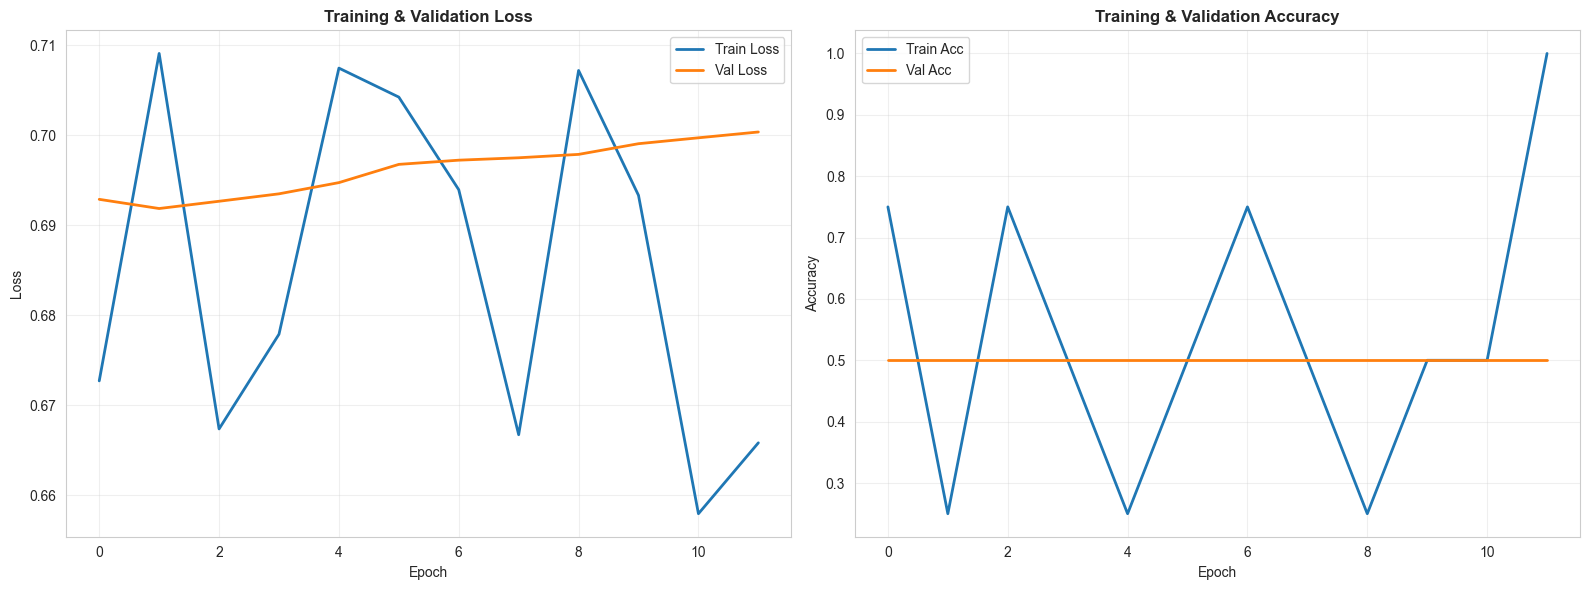

✓ Saved CNN model to models\cnn_encoder.keras

STEP 3: TRAINING HYBRID CNN+SVM CLASSIFIER

🔧 Extracting hybrid features for SVM training...
✓ Hybrid features shape: (4, 138)

🚀 Training SVM (kernel=rbf)...
[LibSVM]✓ SVM Training Accuracy: 1.0000
✓ Hybrid features shape: (2, 138)
✓ SVM Validation Accuracy: 0.5000
✓ Saved SVM to models\hybrid_svm.pkl

FINAL EVALUATION ON TEST SET
✓ Hybrid features shape: (2, 138)
✓ Hybrid features shape: (2, 138)

Test Set Evaluation
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
ROC-AUC:   0.0000

              precision    recall  f1-score   support

  Dissimilar       1.00      1.00      1.00         1
     Similar       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



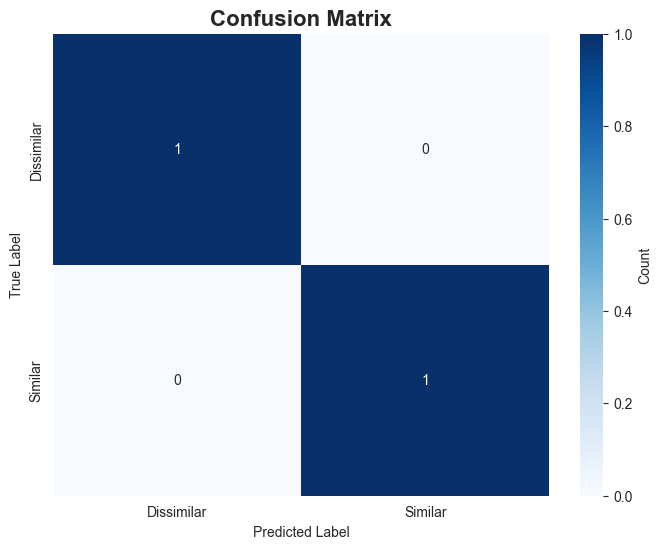

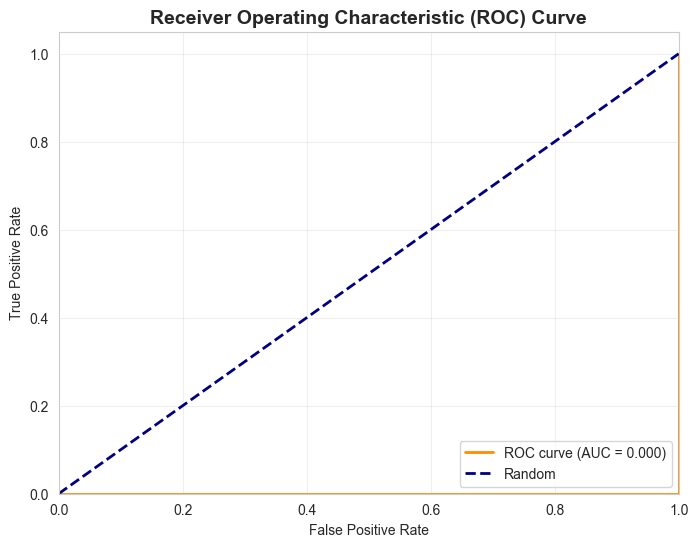


✅ TRAINING COMPLETE!
   Models saved to: models/
   Results saved to: results/

🎯 Next Step: Implement inference API (Step 5)


In [10]:
# STEP 2 & 3: CNN+SVM ARCHITECTURE WITH ADVANCED FEATURE ENGINEERING
# =============================================================================
# This notebook builds a hybrid CNN+SVM model for trademark similarity detection
# Input: Processed CSV from Step 1
# Output: Trained models + evaluation metrics
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import pickle
import json
from pathlib import Path
from datetime import datetime

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Machine Learning
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Feature Engineering (from Step 1)
import jellyfish
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 80)
print("STEP 2 & 3: CNN+SVM HYBRID MODEL WITH LINGUISTIC FEATURES")
print("=" * 80)

# =============================================================================
# CONFIGURATION
# =============================================================================

class ModelConfig:
    """Configuration for model training"""
    def __init__(self):
        # Data - Load from pipeline config
        try:
            with open('pipeline_config.json', 'r') as f:
                pipeline_cfg = json.load(f)
            self.DATA_FILE = pipeline_cfg['processed_data_file']
            print(f"✅ Using dataset from Step 1: {self.DATA_FILE}")
        except FileNotFoundError:
            raise FileNotFoundError("Run Step 1 first to generate the processed dataset!")
        
        # Split sizes
        self.TEST_SIZE = 0.15
        self.VAL_SIZE = 0.15
        
        # CNN Architecture
        self.MAX_SEQUENCE_LENGTH = 50
        self.MAX_VOCAB_SIZE = 10000
        self.EMBEDDING_DIM = 128
        self.CNN_FILTERS = [128, 64, 32]
        self.CNN_KERNEL_SIZES = [3, 4, 5]
        self.DROPOUT_RATE = 0.5
        
        # Training
        self.BATCH_SIZE = 32
        self.EPOCHS = 50
        self.LEARNING_RATE = 0.001
        self.EARLY_STOPPING_PATIENCE = 10
        
        # SVM
        self.SVM_KERNEL = 'rbf'
        self.SVM_C = 1.0
        self.SVM_GAMMA = 'scale'
        
        # Output directories
        self.MODEL_DIR = Path('models')
        self.RESULTS_DIR = Path('results')
        
        # Create directories
        self.MODEL_DIR.mkdir(exist_ok=True)
        self.RESULTS_DIR.mkdir(exist_ok=True)

# Initialize config
config = ModelConfig()

# =============================================================================
# DATA LOADER
# =============================================================================

class TrademarkDataLoader:
    """Load and prepare trademark data"""
    
    def __init__(self, file_path: str):
        self.df = pd.read_csv(file_path)
        print(f"✓ Loaded {len(self.df)} trademark pairs")
        print(f"  Positive: {(self.df['label']==1).sum()}")
        print(f"  Negative: {(self.df['label']==0).sum()}")
    
    def get_text_pairs(self) -> Tuple[List[str], List[str]]:
        """Get wordmark pairs as text lists"""
        mark1 = self.df['mark1_wordmark'].fillna('').tolist()
        mark2 = self.df['mark2_wordmark'].fillna('').tolist()
        return mark1, mark2
    
    def get_labels(self) -> np.ndarray:
        """Get similarity labels"""
        return self.df['label'].values
    
    def get_linguistic_features(self) -> np.ndarray:
        """Extract all pre-computed linguistic features from Step 1"""
        feature_cols = [
            'visual_levenshtein', 'visual_jaro_winkler',
            'soundex_match', 'metaphone_match',
            'semantic_similarity_en', 'semantic_similarity_ha', 'semantic_similarity_yo',
            'length_diff', 'mark1_length', 'mark2_length'
        ]
        
        features = self.df[feature_cols].fillna(0).values
        print(f"✓ Extracted {features.shape[1]} linguistic features")
        return features
    
    def split_data(self, test_size=0.15, val_size=0.15, random_state=42):
        """Stratified train/val/test split"""
        mark1, mark2 = self.get_text_pairs()
        labels = self.get_labels()
        features = self.get_linguistic_features()
        
        # First split: train+val vs test
        train_val_size = 1.0 - test_size
        X_train_val_m1, X_test_m1, X_train_val_m2, X_test_m2, \
        y_train_val, y_test, features_train_val, features_test = train_test_split(
            mark1, mark2, labels, features,
            test_size=test_size,
            stratify=labels,
            random_state=random_state
        )
        
        # Second split: train vs val
        val_size_adjusted = val_size / train_val_size
        X_train_m1, X_val_m1, X_train_m2, X_val_m2, \
        y_train, y_val, features_train, features_val = train_test_split(
            X_train_val_m1, X_train_val_m2, y_train_val, features_train_val,
            test_size=val_size_adjusted,
            stratify=y_train_val,
            random_state=random_state
        )
        
        print(f"\n📊 Data Split:")
        print(f"   Train: {len(y_train)} ({(y_train==1).sum()} positive)")
        print(f"   Val:   {len(y_val)} ({(y_val==1).sum()} positive)")
        print(f"   Test:  {len(y_test)} ({(y_test==1).sum()} positive)")
        
        return {
            'train': (X_train_m1, X_train_m2, y_train, features_train),
            'val': (X_val_m1, X_val_m2, y_val, features_val),
            'test': (X_test_m1, X_test_m2, y_test, features_test)
        }

# =============================================================================
# CHARACTER-LEVEL CNN ENCODER
# =============================================================================

class CharacterCNNEncoder:
    """Character-level CNN for trademark text encoding"""
    
    def __init__(self, config: ModelConfig):
        self.config = config
        self.tokenizer = None
        self.model = None
        self.encoder = None
        self.history = None
    
    def build_tokenizer(self, texts: List[str]):
        """Build character-level tokenizer"""
        self.tokenizer = Tokenizer(
            num_words=self.config.MAX_VOCAB_SIZE,
            char_level=True,
            oov_token='<UNK>'
        )
        self.tokenizer.fit_on_texts(texts)
        print(f"✓ Built character tokenizer (vocab size: {len(self.tokenizer.word_index)})")
    
    def encode_texts(self, texts: List[str]) -> np.ndarray:
        """Convert texts to padded sequences"""
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(
            sequences,
            maxlen=self.config.MAX_SEQUENCE_LENGTH,
            padding='post',
            truncating='post'
        )
        return padded
    
    def build_siamese_cnn(self):
        """Build Siamese CNN architecture for pair comparison"""
        # Shared character encoder
        char_input = layers.Input(shape=(self.config.MAX_SEQUENCE_LENGTH,), name='char_input')
        
        # Embedding layer
        x = layers.Embedding(
            input_dim=len(self.tokenizer.word_index) + 1,
            output_dim=self.config.EMBEDDING_DIM,
            input_length=self.config.MAX_SEQUENCE_LENGTH,
            name='embedding'
        )(char_input)
        
        # Multiple parallel CNN branches (different kernel sizes)
        conv_outputs = []
        for i, (filters, kernel_size) in enumerate(
            zip(self.config.CNN_FILTERS, self.config.CNN_KERNEL_SIZES)
        ):
            conv = layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                name=f'conv_{kernel_size}'
            )(x)
            pool = layers.GlobalMaxPooling1D(name=f'pool_{kernel_size}')(conv)
            conv_outputs.append(pool)
        
        # Concatenate all CNN outputs
        concatenated = layers.Concatenate(name='concat_cnn')(conv_outputs)
        
        # Dense layers
        dense = layers.Dense(256, activation='relu', name='dense_1')(concatenated)
        dense = layers.Dropout(self.config.DROPOUT_RATE, name='dropout_1')(dense)
        dense = layers.Dense(128, activation='relu', name='dense_2')(dense)
        dense = layers.Dropout(self.config.DROPOUT_RATE, name='dropout_2')(dense)
        embedding_output = layers.Dense(64, activation='relu', name='embedding_output')(dense)
        
        # Build shared encoder
        self.encoder = models.Model(inputs=char_input, outputs=embedding_output, name='cnn_encoder')
        
        # Siamese architecture
        input_mark1 = layers.Input(shape=(self.config.MAX_SEQUENCE_LENGTH,), name='mark1')
        input_mark2 = layers.Input(shape=(self.config.MAX_SEQUENCE_LENGTH,), name='mark2')
        
        # Get embeddings for both marks using shared encoder
        embedding_mark1 = self.encoder(input_mark1)
        embedding_mark2 = self.encoder(input_mark2)
        
        # Compute similarity features
        # 1. Absolute difference
        diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([embedding_mark1, embedding_mark2])
        
        # 2. Element-wise product
        product = layers.Multiply()([embedding_mark1, embedding_mark2])
        
        # 3. Concatenate all
        merged = layers.Concatenate()([embedding_mark1, embedding_mark2, diff, product])
        
        # Classification head
        x = layers.Dense(128, activation='relu', name='classifier_dense_1')(merged)
        x = layers.Dropout(self.config.DROPOUT_RATE, name='classifier_dropout')(x)
        x = layers.Dense(64, activation='relu', name='classifier_dense_2')(x)
        output = layers.Dense(1, activation='sigmoid', name='output')(x)
        
        # Build full model
        self.model = models.Model(
            inputs=[input_mark1, input_mark2],
            outputs=output,
            name='siamese_cnn'
        )
        
        # Compile
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=self.config.LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy', metrics.Precision(), metrics.Recall()]
        )
        
        print("\n🏗️  CNN Architecture:")
        self.model.summary()
        
        return self.model
    
    def train(self, train_data, val_data, epochs=50):
        """Train the Siamese CNN"""
        X_train_m1, X_train_m2, y_train = train_data
        X_val_m1, X_val_m2, y_val = val_data
        
        # Callbacks
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=self.config.EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
        
        checkpoint = callbacks.ModelCheckpoint(
            str(config.MODEL_DIR / 'best_cnn_model.h5'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
        
        # Train
        print("\n🚀 Training CNN...")
        self.history = self.model.fit(
            [X_train_m1, X_train_m2], y_train,
            validation_data=([X_val_m1, X_val_m2], y_val),
            epochs=epochs,
            batch_size=self.config.BATCH_SIZE,
            callbacks=[early_stop, reduce_lr, checkpoint],
            verbose=1
        )
        
        return self.history
    
    def extract_embeddings(self, texts: List[str]) -> np.ndarray:
        """Extract CNN embeddings for texts"""
        sequences = self.encode_texts(texts)
        embeddings = self.encoder.predict(sequences, verbose=0)
        return embeddings
    
    def save(self, path: str):
        """Save model and tokenizer"""
        # Add .keras extension
        model_path = f"{path}.keras"
        self.model.save(model_path)
        with open(f"{path}_tokenizer.pkl", 'wb') as f:
            pickle.dump(self.tokenizer, f)
        print(f"✓ Saved CNN model to {model_path}")

    def load(self, path: str):
        """Load model and tokenizer"""
        # Add .keras extension
        model_path = f"{path}.keras"
        self.model = keras.models.load_model(model_path)
        with open(f"{path}_tokenizer.pkl", 'rb') as f:
            self.tokenizer = pickle.load(f)
        # Rebuild encoder
        self.encoder = models.Model(
            inputs=self.model.get_layer('cnn_encoder').input,
            outputs=self.model.get_layer('cnn_encoder').output
        )
        print(f"✓ Loaded CNN model from {model_path}")

# =============================================================================
# HYBRID CNN+SVM CLASSIFIER
# =============================================================================

class HybridCNNSVM:
    """Combines CNN embeddings with linguistic features for SVM classification"""
    
    def __init__(self, cnn_encoder: CharacterCNNEncoder, config: ModelConfig):
        self.cnn_encoder = cnn_encoder
        self.config = config
        self.svm = None
        self.scaler = StandardScaler()
    
    def extract_hybrid_features(
        self, 
        mark1_texts: List[str], 
        mark2_texts: List[str],
        linguistic_features: np.ndarray
    ) -> np.ndarray:
        """Combine CNN embeddings + linguistic features"""
        # Get CNN embeddings
        emb1 = self.cnn_encoder.extract_embeddings(mark1_texts)
        emb2 = self.cnn_encoder.extract_embeddings(mark2_texts)
        
        # Concatenate: [emb1, emb2, linguistic_features]
        hybrid_features = np.hstack([emb1, emb2, linguistic_features])
        
        print(f"✓ Hybrid features shape: {hybrid_features.shape}")
        return hybrid_features
    
    def train(self, train_data, val_data=None):
        """Train SVM on hybrid features"""
        X_train_m1, X_train_m2, y_train, features_train = train_data
        
        print("\n🔧 Extracting hybrid features for SVM training...")
        X_train_hybrid = self.extract_hybrid_features(
            X_train_m1, X_train_m2, features_train
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train_hybrid)
        
        # Train SVM
        print(f"\n🚀 Training SVM (kernel={self.config.SVM_KERNEL})...")
        self.svm = SVC(
            kernel=self.config.SVM_KERNEL,
            C=self.config.SVM_C,
            gamma=self.config.SVM_GAMMA,
            probability=True,
            random_state=42,
            verbose=True
        )
        self.svm.fit(X_train_scaled, y_train)
        
        # Evaluate on training data
        train_pred = self.svm.predict(X_train_scaled)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"✓ SVM Training Accuracy: {train_acc:.4f}")
        
        # Evaluate on validation if provided
        if val_data is not None:
            X_val_m1, X_val_m2, y_val, features_val = val_data
            X_val_hybrid = self.extract_hybrid_features(
                X_val_m1, X_val_m2, features_val
            )
            X_val_scaled = self.scaler.transform(X_val_hybrid)
            val_pred = self.svm.predict(X_val_scaled)
            val_acc = accuracy_score(y_val, val_pred)
            print(f"✓ SVM Validation Accuracy: {val_acc:.4f}")
    
    def predict(self, mark1_texts: List[str], mark2_texts: List[str], 
                linguistic_features: np.ndarray) -> np.ndarray:
        """Predict similarity labels"""
        X_hybrid = self.extract_hybrid_features(mark1_texts, mark2_texts, linguistic_features)
        X_scaled = self.scaler.transform(X_hybrid)
        return self.svm.predict(X_scaled)
    
    def predict_proba(self, mark1_texts: List[str], mark2_texts: List[str],
                      linguistic_features: np.ndarray) -> np.ndarray:
        """Predict similarity probabilities"""
        X_hybrid = self.extract_hybrid_features(mark1_texts, mark2_texts, linguistic_features)
        X_scaled = self.scaler.transform(X_hybrid)
        return self.svm.predict_proba(X_scaled)[:, 1]
    
    def save(self, path: str):
        """Save SVM and scaler"""
        with open(path, 'wb') as f:
            pickle.dump({'svm': self.svm, 'scaler': self.scaler}, f)
        print(f"✓ Saved SVM to {path}")
    
    def load(self, path: str):
        """Load SVM and scaler"""
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.svm = data['svm']
            self.scaler = data['scaler']
        print(f"✓ Loaded SVM from {path}")

# =============================================================================
# EVALUATOR
# =============================================================================

class ModelEvaluator:
    """Comprehensive model evaluation and visualization"""
    
    @staticmethod
    def evaluate(y_true, y_pred, y_proba, dataset_name="Test"):
        """Calculate all metrics"""
        metrics_dict = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_proba)
        }
        
        print(f"\n{'='*60}")
        print(f"{dataset_name} Set Evaluation")
        print(f"{'='*60}")
        print(f"Accuracy:  {metrics_dict['accuracy']:.4f}")
        print(f"Precision: {metrics_dict['precision']:.4f}")
        print(f"Recall:    {metrics_dict['recall']:.4f}")
        print(f"F1 Score:  {metrics_dict['f1']:.4f}")
        print(f"ROC-AUC:   {metrics_dict['roc_auc']:.4f}")
        
        # Classification report
        print(f"\n{classification_report(y_true, y_pred, target_names=['Dissimilar', 'Similar'])}")
        
        return metrics_dict
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, save_path=None):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Dissimilar', 'Similar'],
                   yticklabels=['Dissimilar', 'Similar'],
                   cbar_kws={'label': 'Count'})
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_roc_curve(y_true, y_proba, save_path=None):
        """Plot ROC curve"""
        fpr, tpr, thresholds = roc_curve(y_true, y_proba)
        roc_auc = roc_auc_score(y_true, y_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve', 
                 fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_training_history(history, save_path=None):
        """Plot CNN training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Loss
        ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
        ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training & Validation Loss', fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Accuracy
        ax2.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
        ax2.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training & Validation Accuracy', fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================

def main():
    """Run complete training pipeline"""
    
    print("\n" + "="*80)
    print("STEP 2: TRAINING CNN+SVM HYBRID MODEL")
    print("="*80)
    
    # 1. Load Data
    print("\n📂 Loading preprocessed data...")
    loader = TrademarkDataLoader(config.DATA_FILE)
    data_splits = loader.split_data(
        test_size=config.TEST_SIZE,
        val_size=config.VAL_SIZE
    )
    
    # 2. Build Character-level CNN
    print("\n🏗️  Building Character-level CNN Encoder...")
    cnn = CharacterCNNEncoder(config)
    
    # Build tokenizer on all training text
    all_train_texts = data_splits['train'][0] + data_splits['train'][1]
    cnn.build_tokenizer(all_train_texts)
    
    # Encode all datasets
    print("\n🔤 Encoding texts to sequences...")
    train_m1_seq = cnn.encode_texts(data_splits['train'][0])
    train_m2_seq = cnn.encode_texts(data_splits['train'][1])
    val_m1_seq = cnn.encode_texts(data_splits['val'][0])
    val_m2_seq = cnn.encode_texts(data_splits['val'][1])
    test_m1_seq = cnn.encode_texts(data_splits['test'][0])
    test_m2_seq = cnn.encode_texts(data_splits['test'][1])
    
    # Build and train CNN
    cnn.build_siamese_cnn()
    history = cnn.train(
        train_data=(train_m1_seq, train_m2_seq, data_splits['train'][2]),
        val_data=(val_m1_seq, val_m2_seq, data_splits['val'][2]),
        epochs=config.EPOCHS
    )
    
    # Plot training history
    ModelEvaluator.plot_training_history(
        history,
        save_path=config.RESULTS_DIR / 'cnn_training_history.png'
    )
    
    # Save CNN
    cnn.save(str(config.MODEL_DIR / 'cnn_encoder'))
    
    # 3. Train Hybrid CNN+SVM
    print("\n" + "="*80)
    print("STEP 3: TRAINING HYBRID CNN+SVM CLASSIFIER")
    print("="*80)
    
    hybrid_model = HybridCNNSVM(cnn, config)
    hybrid_model.train(
        train_data=data_splits['train'],
        val_data=data_splits['val']
    )
    
    # Save SVM
    hybrid_model.save(str(config.MODEL_DIR / 'hybrid_svm.pkl'))
    
    # 4. Evaluate on Test Set
    print("\n" + "="*80)
    print("FINAL EVALUATION ON TEST SET")
    print("="*80)
    
    X_test_m1, X_test_m2, y_test, features_test = data_splits['test']
    
    # Predictions
    y_pred = hybrid_model.predict(X_test_m1, X_test_m2, features_test)
    y_proba = hybrid_model.predict_proba(X_test_m1, X_test_m2, features_test)
    
    # Evaluate
    eval_metrics = ModelEvaluator.evaluate(y_test, y_pred, y_proba, "Test")
    
    # Visualizations
    ModelEvaluator.plot_confusion_matrix(
        y_test, y_pred,
        save_path=config.RESULTS_DIR / 'confusion_matrix.png'
    )
    
    ModelEvaluator.plot_roc_curve(
        y_test, y_proba,
        save_path=config.RESULTS_DIR / 'roc_curve.png'
    )
    
    # 5. Save Results
    results = {
        'metrics': eval_metrics,
        'data_splits': {
            'train_size': len(data_splits['train'][2]),
            'val_size': len(data_splits['val'][2]),
            'test_size': len(data_splits['test'][2])
        },
        'timestamp': datetime.now().isoformat()
    }
    
    with open(config.RESULTS_DIR / 'evaluation_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print("\n✅ TRAINING COMPLETE!")
    print(f"   Models saved to: {config.MODEL_DIR}/")
    print(f"   Results saved to: {config.RESULTS_DIR}/")
    print("\n🎯 Next Step: Implement inference API (Step 5)")
    
    return hybrid_model, eval_metrics

# Run training
if __name__ == "__main__":
    hybrid_model, metrics = main()